In [1]:
!wget https://covid.ourworldindata.org/data/owid-covid-data.csv -O world.csv

--2020-10-07 11:30:36--  https://covid.ourworldindata.org/data/owid-covid-data.csv
Resolving covid.ourworldindata.org (covid.ourworldindata.org)... 2a03:b0c0:3:d0::d24:5001, 2a03:b0c0:3:e0::32e:b001, 157.230.120.63, ...
Connecting to covid.ourworldindata.org (covid.ourworldindata.org)|2a03:b0c0:3:d0::d24:5001|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10664426 (10M) [text/csv]
Saving to: ‘world.csv’

world.csv           100%[===================>]  10,17M   757KB/s    in 8,1s    

2020-10-07 11:30:45 (1,25 MB/s) - ‘world.csv’ saved [10664426/10664426]



In [2]:
!wget https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv -O usa.csv

--2020-10-07 11:30:45--  https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.192.133, 151.101.128.133, 151.101.64.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.192.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 398619 (389K) [text/plain]
Saving to: ‘usa.csv’

usa.csv             100%[===================>] 389,28K   591KB/s    in 0,7s    

2020-10-07 11:30:46 (591 KB/s) - ‘usa.csv’ saved [398619/398619]



https://data.ers.usda.gov/reports.aspx?ID=17827

In [3]:
import pandas as pd
from yo_ds import *

In [4]:
world0 = pd.read_csv('world.csv')
world0 = world0[['continent','location','date','new_cases_per_million','new_deaths_per_million']]
world0 = world0.rename(columns={'new_cases_per_million': 'cases', 'new_deaths_per_million': 'deaths'})


In [5]:
world0.continent.unique()

array(['North America', 'Asia', 'Africa', 'Europe', 'South America',
       'Oceania', nan], dtype=object)

In [6]:
countries = list(world0.loc[world0.continent.isin(['Europe','South America','Asia'])].location.unique())
#countries+=['Israel']
world1 = world0.loc[world0.location.isin(countries)]
world1.head()

,continent,location,date,cases,deaths
203,Asia,Afghanistan,2019-12-31,0.0,0.0
204,Asia,Afghanistan,2020-01-01,0.0,0.0
205,Asia,Afghanistan,2020-01-02,0.0,0.0
206,Asia,Afghanistan,2020-01-03,0.0,0.0
207,Asia,Afghanistan,2020-01-04,0.0,0.0


In [7]:
world = world1

In [8]:
usa0 = pd.read_csv('usa.csv')
pds = []
for state in Query.en(usa0.state.unique()).feed(fluq.with_progress_bar()):
    tdf = usa0.loc[usa0.state==state]
    tdf = tdf.sort_values('date')
    for column in ['cases','deaths']:
        oc = 'old_'+column
        tdf[oc] = tdf[column].shift(1)
        tdf[column] = tdf[column]-tdf[oc]
        tdf = tdf.drop(oc,axis=1)
    tdf = tdf.dropna()
    pds.append(tdf)
usa1 = pd.concat(pds, axis=0)
usa1.loc[usa1.deaths<0].shape
usa1

,date,state,fips,cases,deaths
1,2020-01-22,Washington,53,0.0,0.0
2,2020-01-23,Washington,53,0.0,0.0
4,2020-01-24,Washington,53,0.0,0.0
7,2020-01-25,Washington,53,0.0,0.0
11,2020-01-26,Washington,53,0.0,0.0
...,...,...,...,...,...
11765,2020-10-02,Northern Mariana Islands,69,0.0,0.0
11820,2020-10-03,Northern Mariana Islands,69,0.0,0.0
11875,2020-10-04,Northern Mariana Islands,69,3.0,0.0
11930,2020-10-05,Northern Mariana Islands,69,2.0,0.0


In [9]:
states = pd.read_csv('usa_population.csv')
print(usa1.loc[~usa1.state.isin(states.State)].state.unique())
usa2 = usa1.merge(states.set_index('State'),left_on='state', right_index=True)
usa2.cases = 1000000*usa2.cases/usa2.Pop2019.str.replace(',','').astype(float)
usa2.deaths = 1000000*usa2.deaths/usa2.Pop2019.str.replace(',','').astype(float)
usa2 = usa2[['date','state','cases','deaths']]
usa2 = usa2.rename(columns={'state':'location'})
usa2['continent']='USA'
usa2.head()

['Virgin Islands' 'Guam' 'Northern Mariana Islands']


,date,location,cases,deaths,continent
1,2020-01-22,Washington,0.0,0.0,USA
2,2020-01-23,Washington,0.0,0.0,USA
4,2020-01-24,Washington,0.0,0.0,USA
7,2020-01-25,Washington,0.0,0.0,USA
11,2020-01-26,Washington,0.0,0.0,USA


In [10]:
usa = usa2

In [11]:
bdf = pd.concat([world,usa])
bdf.date = pd.to_datetime(bdf.date)

/home/yura/anaconda3/envs/bsys/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [13]:
dfs = []
for loc in bdf.location.unique():
    df = bdf.loc[bdf.location==loc].copy().fillna(0)
    df['date'] = pd.to_datetime(df.date)
    df['total_deaths'] = df.deaths.cumsum()
    df['total_cases'] = df.cases.cumsum()
    dfs.append(df)


sdf = pd.concat(dfs,axis=0)

In [18]:
adf = (sdf
       .groupby(['continent','location',sdf.date.dt.to_period('W')])
       .aggregate(dict(deaths='sum',total_deaths='max'))
       .reset_index()
      )

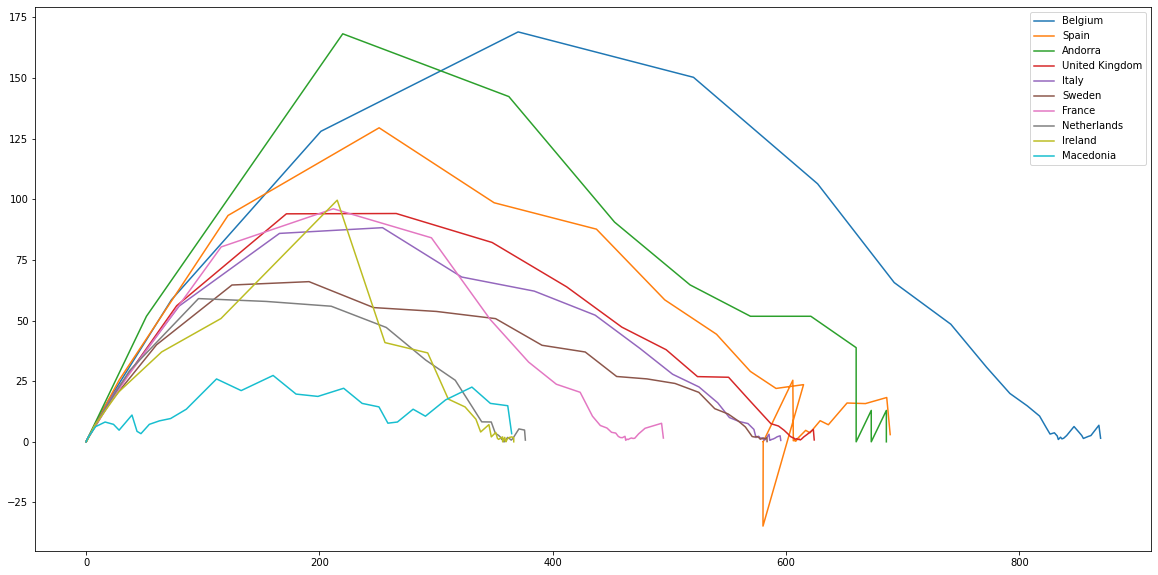

In [38]:
def make_plot(sdf, filtr, page_from, page_to):
    locs = adf.loc[filtr].groupby('location').total_deaths.max().sort_values(ascending=False).index[page_from:page_to]
    _, ax = plt.subplots(1,1,figsize=(20,10))
    for l in locs:
        ssdf = sdf.loc[sdf.location==l].sort_values('date')
        ax.plot(ssdf.total_deaths, ssdf.deaths, label=l)
    ax.legend()

make_plot(adf, (adf.continent=='Europe') & (adf.location!='San Marino'), 0, 10)

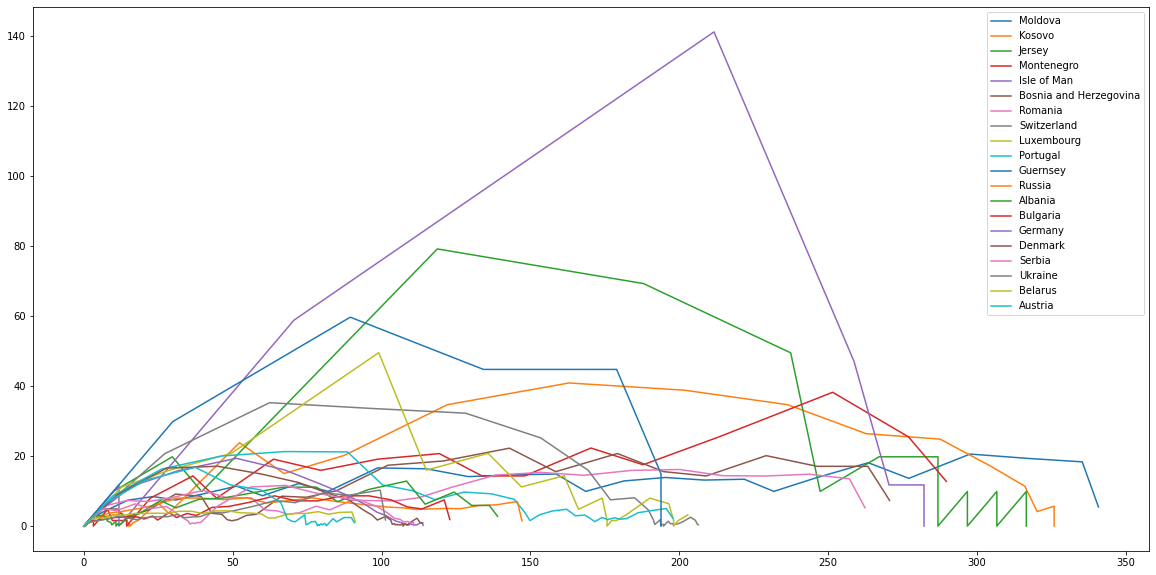

In [36]:
make_plot(adf, (adf.continent=='Europe') & (adf.location!='San Marino'), 10, 30)

In [34]:
adf.loc[adf.location=='Isle of Man']

,continent,location,date,deaths,total_deaths
2518,Europe,Isle of Man,2020-03-16/2020-03-22,0.000,0.000
2519,Europe,Isle of Man,2020-03-23/2020-03-29,0.000,0.000
2520,Europe,Isle of Man,2020-03-30/2020-04-05,11.760,11.760
2521,Europe,Isle of Man,2020-04-06/2020-04-12,0.000,11.760
2522,Europe,Isle of Man,2020-04-13/2020-04-19,58.802,70.562
2523,Europe,Isle of Man,2020-04-20/2020-04-26,141.123,211.685
2524,Europe,Isle of Man,2020-04-27/2020-05-03,47.041,258.726
2525,Europe,Isle of Man,2020-05-04/2020-05-10,11.760,270.486
2526,Europe,Isle of Man,2020-05-11/2020-05-17,11.760,282.246
2527,Europe,Isle of Man,2020-05-18/2020-05-24,0.000,282.246
